In [12]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem 
from rdkit.Chem import AllChem 

from mordred import Calculator, descriptors

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


from ngboost import NGBRegressor, NGBClassifier
from ngboost.distns import Bernoulli

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import accuracy_score, roc_auc_score

In [13]:
def mfs(s):
    return Chem.MolFromSmiles(s)

def mts(m):
    return Chem.MolToCXSmiles(m)

def sanitize_smiles(smi):
    m = Chem.MolFromSmiles(smi) 
    Chem.SanitizeMol(m)
    return Chem.MolToSmiles(m)

def featurize_regression(df, features='ecfp', num_folds=10, fold_size=8, random_seed=100700, make_holdout=False,
                        smiles_col='smiles', target_col='standard_value_pic50'):
    ''' prepare the data for regression setting
    '''
    np.random.seed(random_seed)
    smiles = df[smiles_col].tolist()
    #y = df_regression.abl1_pIC50.values.reshape(-1, 1)
    y = df[target_col].values.reshape(-1, 1)
    print(np.isnan(np.sum(y)))
    mols = [mfs(s) for s in smiles]
    if features=='ecfp':
        X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in mols]).astype(np.float32)
        
    elif features=='mordred':
        calc=Calculator(descriptors,ignore_3D=True,version='1.0.0')
        mord_df = calc.pandas(mols)
        mord_df = mord_df.select_dtypes(exclude=['object', 'bool'])
        X = mord_df.values
    else:
        
        raise NotImplementedError
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    folds = []
    
    for fold_ix in range(num_folds):
        
        X_tr = X[indices[fold_size:], :]
        y_tr = y[indices[fold_size:], :]

        #scaler = StandardScaler()
        #scaler.fit(y_tr)
        #y_tr = scaler.transform(y_tr)

        X_te = X[indices[:fold_size], :]
        y_te = y[indices[:fold_size], :]

        #y_te = scaler.transform(y_te)

        folds.append({'X_tr':X_tr, 'y_tr':y_tr, 'X_te':X_te, 'y_te':y_te,}) #'scaler': scaler})

        indices = np.roll(indices, fold_size)

    return folds

def get_metrics_regression(true, pred):
    true, pred = true.ravel(), pred.ravel()
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = mean_squared_error(true, pred)
    pears = pearsonr(true, pred)[0]
    spear = spearmanr(true, pred)[0]
    return {'r2':r2, 'mae': mae, 'rmse': rmse, 'pears': pears, 'spear':spear}

def get_fold_metrics(metrics):
    fold_metrics={}
    for key in metrics[0].keys():
        key_metrics=[]
        for m in metrics:
            key_metrics.append(m[key])
        fold_metrics[f'{key}_mean'] = np.mean(key_metrics)
        fold_metrics[f'{key}_stderr'] = np.std(key_metrics) / np.sqrt(len(key_metrics))
    return fold_metrics


## Load data from ChemBL

In [14]:
df = pd.read_csv(
            'chembl/DOWNLOAD-PpkGEu4t-60i_qi9nxk_5jQ0R7-td_VYyC4y-fYvh50=.csv', 
            delimiter=';',
            on_bad_lines='skip'
        )
print(df.shape)

(2190, 45)


In [15]:
cols_to_keep = ['Smiles', 'Molecular Weight', 'Standard Type', 'Standard Relation', 'Standard Value',
                'Standard Units', 'Assay Type', 'Assay Cell Type', ]
df = df[cols_to_keep]
print(df.shape)
df.head()

(2190, 8)


,Smiles,Molecular Weight,Standard Type,Standard Relation,Standard Value,Standard Units,Assay Type,Assay Cell Type
0,Cc1cccc(NC(=O)N(Cc2ccc(-c3[nH]nc4c3Cc3cc(CN5CC...,568.79,IC50,'=',17239.0,nM,B,None
1,CCc1cc2c(cc1N1CCN(C3CC3)CC1)C(C)(C)c1[nH]c3cc(...,438.58,IC50,'>',5000.0,nM,B,None
2,CCCC(=O)Nc1cccc2c1Cc1c-2n[nH]c1-c1ccsc1,323.42,IC50,'=',9540.0,nM,B,None
3,O=C(O)CNC(=O)c1cccc2c1Cc1c-2n[nH]c1-c1ccsc1,339.38,IC50,'=',5150.0,nM,B,None
4,CN1CCN(CC(=O)Nc2cccc3c2Cc2c-3n[nH]c2-c2csc(C#C...,523.66,IC50,'=',49.0,nM,B,None


In [16]:
# take only the binding assays
df = df[df['Assay Type']=='B']
# get keep rows that have numerical values for standard value, also remove uM IC50s (only 2)
df = df[(~df['Standard Value'].isnull())&(df['Standard Units']=='nM')]

# rename columns

df = df.rename(columns={'Smiles':'smiles', 'Molecular Weight': 'mol_wt',
                        'Standard Type': 'standard_type', 'Standard Relation': 'standard_relation',
                        'Standard Value': 'standard_value', 'Standard Units': 'standard_units',
                        'Assay Type': 'assay_type', 'Assay Cell Type': 'assay_cell_type',
                        })

In [17]:
df

,smiles,mol_wt,standard_type,standard_relation,standard_value,standard_units,assay_type,assay_cell_type
0,Cc1cccc(NC(=O)N(Cc2ccc(-c3[nH]nc4c3Cc3cc(CN5CC...,568.79,IC50,'=',17239.0,nM,B,None
1,CCc1cc2c(cc1N1CCN(C3CC3)CC1)C(C)(C)c1[nH]c3cc(...,438.58,IC50,'>',5000.0,nM,B,None
2,CCCC(=O)Nc1cccc2c1Cc1c-2n[nH]c1-c1ccsc1,323.42,IC50,'=',9540.0,nM,B,None
3,O=C(O)CNC(=O)c1cccc2c1Cc1c-2n[nH]c1-c1ccsc1,339.38,IC50,'=',5150.0,nM,B,None
4,CN1CCN(CC(=O)Nc2cccc3c2Cc2c-3n[nH]c2-c2csc(C#C...,523.66,IC50,'=',49.0,nM,B,None
...,...,...,...,...,...,...,...,...
2183,Cn1cc(-c2ccc(CNc3cc(-c4cnc5cc(OCCN6CCC[C@@H]7O...,550.67,IC50,'=',6.5,nM,B,None
2184,CC(=O)N1CCN([C@H]2C[C@@H](n3cc(-c4cc(O)ccc4F)c...,424.48,IC50,'=',3400.0,nM,B,BaF3
2185,CC(C)n1cc(C(=O)Nc2ccc(Oc3ccnc(NC(=O)C4CC4)c3)c...,561.55,IC50,'>',1000.0,nM,B,None
2186,COC(=O)NC1(c2nc(-c3ccc(C)c(NC(=O)c4cnc5ccccn45...,482.45,IC50,'=',73.0,nM,B,Mo7e


In [18]:
# convert IC50s to mol/L
df['standard_value_M'] = df['standard_value']*1.e-9
# compute pIC50s 
df['standard_value_pic50'] = -np.log10(df['standard_value_M'])

In [19]:
df.head()

,smiles,mol_wt,standard_type,standard_relation,standard_value,standard_units,assay_type,assay_cell_type,standard_value_M,standard_value_pic50
0,Cc1cccc(NC(=O)N(Cc2ccc(-c3[nH]nc4c3Cc3cc(CN5CC...,568.79,IC50,'=',17239.0,nM,B,None,1.723900e-05,4.763488
1,CCc1cc2c(cc1N1CCN(C3CC3)CC1)C(C)(C)c1[nH]c3cc(...,438.58,IC50,'>',5000.0,nM,B,None,5.000000e-06,5.301030
2,CCCC(=O)Nc1cccc2c1Cc1c-2n[nH]c1-c1ccsc1,323.42,IC50,'=',9540.0,nM,B,None,9.540000e-06,5.020452
3,O=C(O)CNC(=O)c1cccc2c1Cc1c-2n[nH]c1-c1ccsc1,339.38,IC50,'=',5150.0,nM,B,None,5.150000e-06,5.288193
4,CN1CCN(CC(=O)Nc2cccc3c2Cc2c-3n[nH]c2-c2csc(C#C...,523.66,IC50,'=',49.0,nM,B,None,4.900000e-08,7.309804


In [20]:
# save values to disk for chemprop
# cols_keep = ['smiles', 'standard_value_pic50']
# df[cols_keep].to_csv('chemprop/kit_pic50.csv',index=False)

## Examine overlap with novel Abl kinase inhibitors

In [22]:
# prepare fingerprints for abl kinase data
abl_df = pd.read_csv('lookup_table.csv')
abl_smi = abl_df['molecule_smi'].tolist()
abl_mols = [mfs(s) for s in abl_smi]
abl_X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in abl_mols]).astype(np.float32)

In [23]:
# prepare c-KIT inhibitor fingerprints
ckit_smi = df['smiles'].tolist()
ckit_mols = [mfs(s) for s in ckit_smi]
ckit_y = df['standard_value_pic50'].values
ckit_X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in ckit_mols]).astype(np.float32)

In [24]:
X_comb = np.concatenate((abl_X, ckit_X))
X_comb.shape

(2220, 2048)

In [25]:
pca = PCA(n_components=2)
X_trans = pca.fit_transform(X_comb)

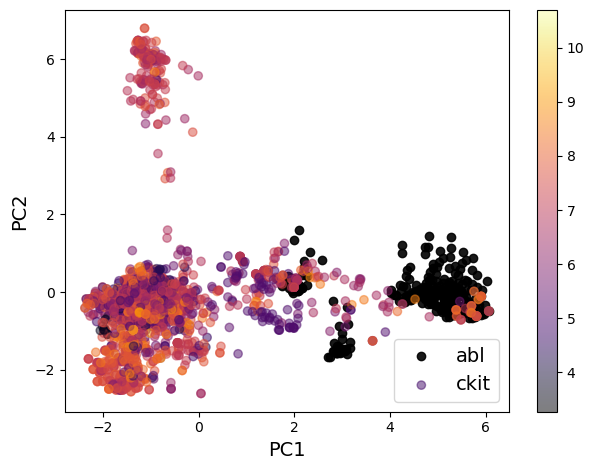

In [26]:
fig, ax = plt.subplots()

ax.scatter(X_trans[:abl_X.shape[0], 0], X_trans[:abl_X.shape[0], 1], label='abl', alpha=0.9,c='k')
im = ax.scatter(X_trans[abl_X.shape[0]:, 0], X_trans[abl_X.shape[0]:, 1], label='ckit', alpha=0.5, c=ckit_y, cmap='inferno')
fig.colorbar(im,)


ax.set_xlabel('PC1',fontsize=14)
ax.set_ylabel('PC2',fontsize=14)
ax.legend(loc='lower right', fontsize=14)

plt.tight_layout()
plt.savefig('bcrabl1_ckit_pca.png', dpi=300)

In [27]:
# save abl inhibitors dataset to disk for chemprop
cols_keep = ['molecule_smi']
abl_df[cols_keep].to_csv('chemprop/abl_smiles.csv',index=False)

## Build regression model for the KIT pIC50 values

### Ideas to improve regression perfomance
   
* remove the points that are > pIC50=9 or 10 (these could be outliers??)
* fiddle with hyperparameter of the NGBoost model (`n_estimators`, `es_patience`, etc. )
* remove the low-variance features and/or redundant features from mordered set
* Use a different model, e.g. Gaussian process or even a GNN for this task
* only take subset of the c-KIT in which each assay attribute is held constant (i.e., cell type, etc. )

In [28]:
folds = featurize_regression(df, features='mordred', num_folds=5, fold_size=390)

False


  1%|▌                                                                                                 | 10/1950 [00:01<02:42, 11.93it/s]

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  4%|████                                                                                              | 81/1950 [00:05<01:28, 21.20it/s]

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 65%|█████████████████████████████████████████████████████████████▉                                  | 1259/1950 [01:04<00:27, 24.74it/s]

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1950/1950 [01:39<00:00, 19.51it/s]


In [29]:
# train regression model on folds
fold_metrics_te = []
fold_metrics_tr = []

for fold in folds:
    X_tr, y_tr = fold['X_tr'], fold['y_tr']
    X_te, y_te = fold['X_te'], fold['y_te']
    
    
    print(X_tr.shape, y_tr.shape)
    print(X_te.shape, y_te.shape)
    
    model = NGBRegressor().fit(X_tr, y_tr)
    
    # train set prediction
    y_preds_tr = model.predict(X_tr)
    y_dists_tr = model.pred_dist(X_tr)
    samples_tr = y_dists_tr.sample(m=50).T
    y_std_tr = np.std(samples_tr, axis=-1)
    y_mu_tr = np.mean(samples_tr, axis=-1)
    
    
    
    # rescale the targets and predictions
    #y_mu_tr = fold['scaler'].inverse_transform(y_mu_tr)
    #y_tr = fold['scaler'].inverse_transform(y_tr)
    
    metrics_tr = get_metrics_regression(y_tr, y_mu_tr)
    fold_metrics_tr.append(metrics_tr)
    
    fold['y_tr_pred_mu'] = y_mu_tr.reshape(-1, 1)
    fold['y_tr_pred_std'] = y_std_tr.reshape(-1, 1)
    

    # test set prediction
    y_preds_te = model.predict(X_te)
    y_dists_te = model.pred_dist(X_te)
    samples_te = y_dists_te.sample(m=50).T
    y_std_te = np.std(samples_te, axis=-1)
    y_mu_te = np.mean(samples_te, axis=-1)
    
    #y_mu_te = fold['scaler'].inverse_transform(y_mu_te)
    #y_te = fold['scaler'].inverse_transform(y_te)
    
    metrics_te = get_metrics_regression(y_te, y_mu_te)
    
    fold_metrics_te.append(metrics_te)
    
    fold['y_te_pred_mu'] = y_mu_te.reshape(-1, 1)
    fold['y_te_pred_std'] = y_std_te.reshape(-1, 1)

(1560, 1155) (1560, 1)
(390, 1155) (390, 1)


/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.5979 val_loss=0.0000 scale=1.0000 norm=1.1453
[iter 100] loss=1.3478 val_loss=0.0000 scale=2.0000 norm=1.8739
[iter 200] loss=1.1798 val_loss=0.0000 scale=1.0000 norm=0.8399
[iter 300] loss=1.0537 val_loss=0.0000 scale=1.0000 norm=0.7857
[iter 400] loss=0.9581 val_loss=0.0000 scale=1.0000 norm=0.7499
(1560, 1155) (1560, 1)
(390, 1155) (390, 1)


/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.5912 val_loss=0.0000 scale=1.0000 norm=1.1382
[iter 100] loss=1.3308 val_loss=0.0000 scale=1.0000 norm=0.9207
[iter 200] loss=1.1486 val_loss=0.0000 scale=1.0000 norm=0.8220
[iter 300] loss=1.0188 val_loss=0.0000 scale=2.0000 norm=1.5375
[iter 400] loss=0.9042 val_loss=0.0000 scale=1.0000 norm=0.7258
(1560, 1155) (1560, 1)
(390, 1155) (390, 1)


/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.5979 val_loss=0.0000 scale=1.0000 norm=1.1444
[iter 100] loss=1.3428 val_loss=0.0000 scale=1.0000 norm=0.9329
[iter 200] loss=1.1590 val_loss=0.0000 scale=1.0000 norm=0.8314
[iter 300] loss=1.0360 val_loss=0.0000 scale=1.0000 norm=0.7804
[iter 400] loss=0.9436 val_loss=0.0000 scale=1.0000 norm=0.7448
(1560, 1155) (1560, 1)
(390, 1155) (390, 1)


/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.5944 val_loss=0.0000 scale=1.0000 norm=1.1412
[iter 100] loss=1.3413 val_loss=0.0000 scale=1.0000 norm=0.9299
[iter 200] loss=1.1738 val_loss=0.0000 scale=1.0000 norm=0.8349
[iter 300] loss=1.0413 val_loss=0.0000 scale=1.0000 norm=0.7790
[iter 400] loss=0.9301 val_loss=0.0000 scale=1.0000 norm=0.7403
(1560, 1155) (1560, 1)
(390, 1155) (390, 1)


/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.5823 val_loss=0.0000 scale=1.0000 norm=1.1319
[iter 100] loss=1.3285 val_loss=0.0000 scale=2.0000 norm=1.8535
[iter 200] loss=1.1499 val_loss=0.0000 scale=2.0000 norm=1.6602
[iter 300] loss=1.0301 val_loss=0.0000 scale=1.0000 norm=0.7806
[iter 400] loss=0.9409 val_loss=0.0000 scale=1.0000 norm=0.7472


In [30]:
fold_stats_tr = get_fold_metrics(fold_metrics_tr)
fold_stats_te = get_fold_metrics(fold_metrics_te)

In [32]:
print(fold_stats_tr)
print('')
print(fold_stats_te)

{'r2_mean': 0.6636193907353857, 'r2_stderr': 0.00636541430702494, 'mae_mean': 0.5387494215427604, 'mae_stderr': 0.005888434852853213, 'rmse_mean': 0.47615322564456886, 'rmse_stderr': 0.008502232973331183, 'pears_mean': 0.844895356084964, 'pears_stderr': 0.003166007963882352, 'spear_mean': 0.8247476129559299, 'spear_stderr': 0.00253977270074879}

{'r2_mean': 0.460922153352662, 'r2_stderr': 0.009008320744433819, 'mae_mean': 0.6825266884245389, 'mae_stderr': 0.006718458619904994, 'rmse_mean': 0.7598514940646564, 'rmse_stderr': 0.012528000812627713, 'pears_mean': 0.6946535113224626, 'pears_stderr': 0.009042410714074647, 'spear_mean': 0.6615450192709027, 'spear_stderr': 0.009848977056110585}


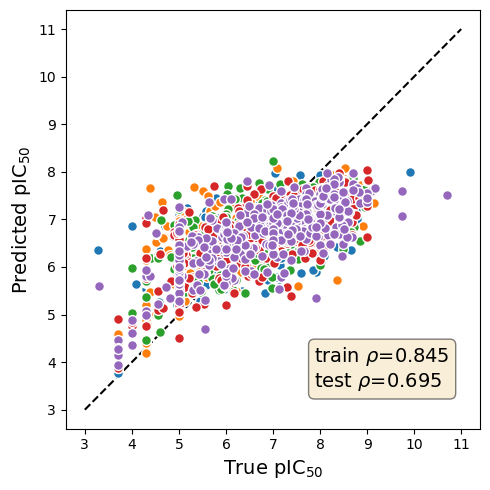

In [40]:
fig, ax = plt.subplots(figsize=(5,5))

for fold in folds:
    ax.scatter(fold['y_te'], fold['y_te_pred_mu'], s=50, edgecolor='white')
    
ax.set_xlabel(r'True pIC$_{50}$',fontsize=14)
ax.set_ylabel(r'Predicted pIC$_{50}$',fontsize=14)

ax.plot([3,11], [3,11], linestyle='--', color='k', zorder=0)

text_str = r'train $\rho$='+f'{round(fold_stats_tr["pears_mean"],3)}'+'\n'+r'test $\rho$='+f'{round(fold_stats_te["pears_mean"],3)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.6, 0.2, text_str, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.tight_layout()

## Train on entire dataset  and predict on Desai molecules

In [60]:
# join dataframes
ckit_smi = df['smiles'].tolist()
abl_smi = abl_df['molecule_smi'].tolist()
smiles = abl_smi + ckit_smi
mols = [mfs(s) for s in smiles]

calc=Calculator(descriptors,ignore_3D=True,version='1.0.0')
mord_df = calc.pandas(mols)
mord_df = mord_df.select_dtypes(exclude=['object', 'bool'])
X = mord_df.values



 13%|████████████▏                                                                                    | 279/2220 [00:14<01:40, 19.32it/s]

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 16%|███████████████▎                                                                                 | 350/2220 [00:18<01:26, 21.57it/s]

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 35%|██████████████████████████████████▎                                                              | 785/2220 [00:40<01:13, 19.51it/s]

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 68%|█████████████████████████████████████████████████████████████████▌                              | 1517/2220 [01:17<01:27,  8.05it/s]

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 80%|████████████████████████████████████████████████████████████████████████████▊                   | 1777/2220 [01:30<00:20, 21.81it/s]

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2220/2220 [01:53<00:00, 19.52it/s]


In [64]:
X_te, X_tr = X[:len(abl_smi),:], X[len(abl_smi):,:]
y_tr = df['standard_value_pic50'].values.reshape(-1,1)

In [71]:
model = NGBRegressor(n_estimators=600, learning_rate=0.1).fit(X_tr, y_tr)

# train set prediction
y_preds_tr = model.predict(X_tr)
y_dists_tr = model.pred_dist(X_tr)
samples_tr = y_dists_tr.sample(m=20).T
y_std_tr = np.std(samples_tr, axis=-1)
y_mu_tr = np.mean(samples_tr, axis=-1)


metrics_tr = get_metrics_regression(y_tr, y_mu_tr)

y_tr_pred_mu = y_mu_tr.reshape(-1, 1)
y_tr_pred_std = y_std_tr.reshape(-1, 1)

# test set prediction
y_preds_te = model.predict(X_te)
y_dists_te = model.pred_dist(X_te)
samples_te = y_dists_te.sample(m=20).T
y_std_te = np.std(samples_te, axis=-1)
y_mu_te = np.mean(samples_te, axis=-1)

y_te_pred_mu = y_mu_te.reshape(-1, 1)
y_te_pred_std = y_std_te.reshape(-1, 1)

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=1.5929 val_loss=0.0000 scale=1.0000 norm=1.1403
[iter 100] loss=0.6282 val_loss=0.0000 scale=1.0000 norm=0.6469
[iter 200] loss=0.2766 val_loss=0.0000 scale=1.0000 norm=0.5493
[iter 300] loss=0.0674 val_loss=0.0000 scale=0.2500 norm=0.1262
[iter 400] loss=-0.0118 val_loss=0.0000 scale=0.0020 norm=0.0010
[iter 500] loss=-0.0323 val_loss=0.0000 scale=0.0010 norm=0.0005


In [72]:
metrics_tr

{'r2': 0.875804398563075,
 'mae': 0.28527011456565715,
 'rmse': 0.1758700745284185,
 'pears': 0.93908605977449,
 'spear': 0.9288995432109407}

/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_4016/1912483638.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_tr, label='original')
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_4016/1912483638.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_te_pred_mu, labe

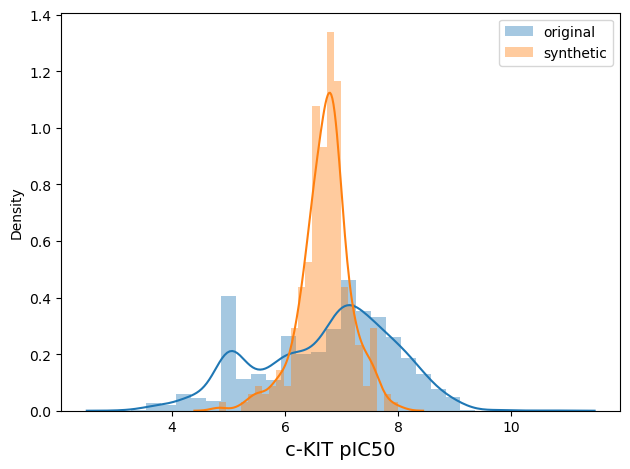

In [87]:
sns.distplot(y_tr, label='original')
sns.distplot(y_te_pred_mu, label='synthetic')
plt.xlabel('c-KIT pIC50',fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('ckit_pic50_vals.png', dpi=300)

/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_4016/2788572666.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(abl_df['abl1_pIC50'])


<AxesSubplot: xlabel='abl1_pIC50', ylabel='Density'>

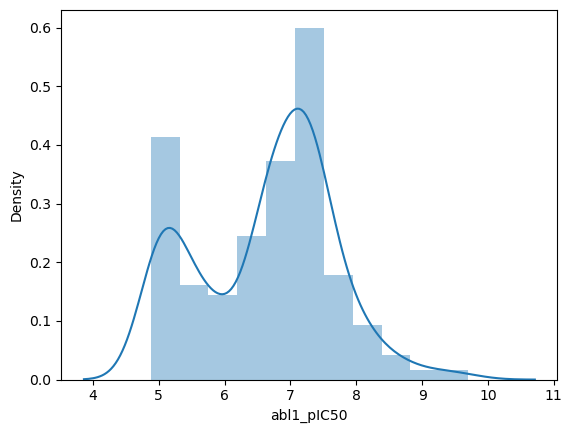

In [88]:
sns.distplot(abl_df['abl1_pIC50'])

In [89]:
# join together the 
abl_df['pred_ckit_pIC50'] = y_te_pred_mu

PearsonRResult(statistic=0.31331081562997676, pvalue=1.461868828879635e-07)


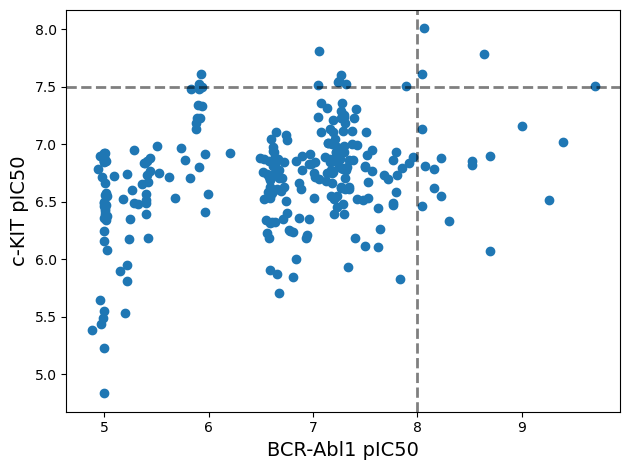

In [98]:
fig, ax = plt.subplots()

ax.scatter(abl_df['abl1_pIC50'], abl_df['pred_ckit_pIC50'])
ax.set_xlabel('BCR-Abl1 pIC50',fontsize=14)
ax.set_ylabel('c-KIT pIC50',fontsize=14)

print(
    pearsonr(abl_df['abl1_pIC50'], abl_df['pred_hyugvbfckit_pIC50'])
)
ax.axhline(7.5, c='k',alpha=0.5, ls='--', lw=2)
ax.axvline(8., c='k',alpha=0.5, ls='--', lw=2)

plt.tight_layout()
plt.savefig('pIC50_correlation.png', dpi=300)

In [99]:
sat_df = abl_df[(abl_df['abl1_pIC50']>8.)&(abl_df['pred_ckit_pIC50']>7.5)]

In [109]:
sat_mols = [mfs(s) for s in sat_df['molecule_smi']]


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment_x,abl1_pIC50,abl1_pIC50_std,pred_ckit_pIC50
0,8-1,22-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(=N)OC)cn12,COC(=N)c1ccc2ncc(C#Cc3cc(C(=O)Nc4ccc(CN5CCN(C)...,1,0.536046,0,7.390089,7.156328,7.229140
1,8-1,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.045757,1.000000,7.610911
2,8-1,22-3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(F)(F)F)cn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0,0.000000,1,7.515735,7.152991,6.909488
3,8-1,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.065502,1.000000,8.009535
4,8-1,22-5,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncc2nccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,9.698970,1.000000,7.508321
...,...,...,...,...,...,...,...,...,...,...,...
265,19,22-23,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C#Cc1ccc(N)nc1,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4ccc(N)nc4)n(C)n...,1,0.985571,0,7.493321,7.067724,6.814434
266,19,22-24,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C#Cc1ccccc1F,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4ccccc4F)n(C)n3)...,1,0.988859,0,7.109972,7.062334,6.892791
267,19,22-25,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C[Si](C)(C)C#Cc1cnc2nccn2c1,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cnc5nccn5c4)n(C...,0,0.000000,1,7.683010,7.071301,6.730346
268,19,22-26,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C[Si](C)(C)C#Cc1cncc2nc[nH]c12,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cncc5nc[nH]c45)...,1,1.000000,1,8.522879,1.000000,6.815527


template_name     8-1
alkyne_name      22-2
Name: 1, dtype: object


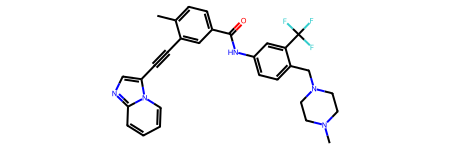

In [111]:
print( sat_df.iloc[0][['template_name', 'alkyne_name']] ) 
sat_mols[0]

template_name     8-1
alkyne_name      22-4
Name: 3, dtype: object


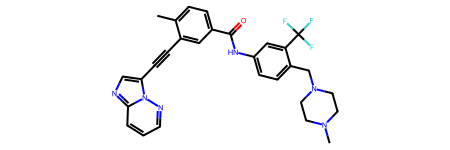

In [112]:
print( sat_df.iloc[1][['template_name', 'alkyne_name']] ) 
sat_mols[1]

template_name     8-1
alkyne_name      22-5
Name: 4, dtype: object


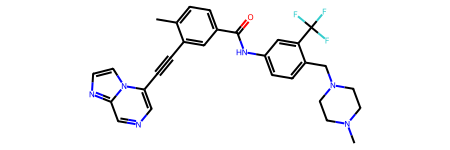

In [113]:
print( sat_df.iloc[2][['template_name', 'alkyne_name']] ) 
sat_mols[2]

template_name     8-1
alkyne_name      22-6
Name: 5, dtype: object


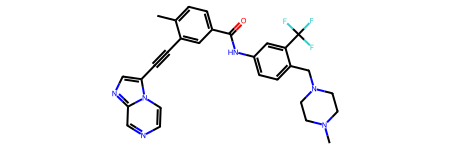

In [115]:
print( sat_df.iloc[3][['template_name', 'alkyne_name']] ) 
sat_mols[3]